In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

import random

from sklearn.datasets.samples_generator import make_blobs

style.use('fivethirtyeight')

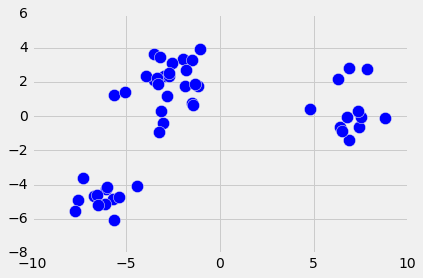

In [13]:
nsamples= 50
ncenters= random.randrange(2,8)
centers = [[1,1,1], [5,5,5], [3,10,10]]

X, _    = make_blobs(n_samples=nsamples, centers=ncenters, cluster_std=1)
plt.scatter(X[:,0], X[:,1], s=150)

colors = 10*["g","r","c","b","k"]

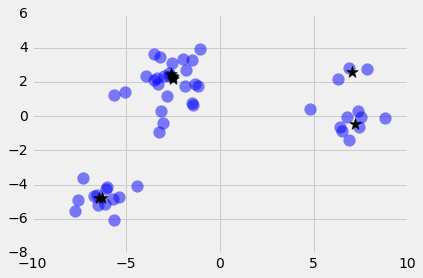

In [14]:
class MeanShift(object):
    def __init__(self, radius=4):
        self.radius = radius
    
    def fit(self, data):
        
        centroids = {}
        
        for i in range(len(data)):
            centroids[i] = data[i]
        
        while True:
            new_centroids = []
            for i in centroids:
                in_bandwidth = []
                centroid = centroids[i]
                for featureset in data:
                    if np.linalg.norm(featureset - centroid) < self.radius:
                        in_bandwidth.append(featureset)
                
                new_centroid = np.average(in_bandwidth, axis=0)
                
                new_centroids.append(tuple(new_centroid))
                
            uniques = sorted(list(set(new_centroids)))
            
            prev_centroids = dict(centroids)
            
            centroids = {}
            for i in range(len(uniques)):
                centroids[i] = np.array(uniques[i])
            
            optimized = True
            
            for i in centroids:
                if not np.array_equal(centroids[i],prev_centroids[i]):
                    optimized = False
                
                if not optimized:
                    break
            
            if optimized:
                break
        
        self.centroids = centroids
        
        def predict(self):
            pass
        
clf = MeanShift(radius=2)
clf.fit(X)

centroids = clf.centroids

plt.scatter(X[:,0], X[:,1], s=150, lw=0, alpha=0.5)

for c in centroids:
    plt.scatter(centroids[c][0], centroids[c][1], color='k', marker='*', s=150)


Part 2: (p42) Automating the Radius and Weighting the Distances
===
---
But we need to manually set radius to a `reasonable value`, which is not 'unsupervised learning'. For the above example, we're able to look at the data and say "yeah, radius=4 looks good", but that's never going to be possible for higher dimensional data sets.

In p42 (that which follows), we will learn how to automate the selection of the radius
- We will set the radius to be large, but have a penalty weight for samples that are far from the current center locations.
- this way, we will check many more samples in the feature-set, but under weight samples that are far from our current centroids.

In [23]:
class MeanShift(object):
    def __init__(self, radius=None, radius_norm_step=100):
        self.radius           = radius
        self.radius_norm_step = radius_norm_step
    
    def fit(self, data):
        
        if self.radius == None:
            # This section chooses a realistic `radius` that corresponds to the data-norm
            all_data_centroid = np.average(data,axis=0)
            all_data_norm     = np.linalg.norm(all_data_centroid)
            self.radius       = all_data_norm / self.radius_norm_step
        
        # This will weight it so that the first element in the centroids is weighted the most
        #   and the last element in the centroids is weighted the least
        weights = [int(i) for i in range(self.radius_norm_step)][::-1]
        
        centroids = {}
        
        for i in range(len(data)):
            centroids[i] = data[i]
        
        while True:
            new_centroids = []
            for i in centroids:
                in_bandwidth = []
                centroid = centroids[i]
                
                for featureset in data:
                    distance = np.linalg.norm(featureset - centroid)
                    if distance == 0:
                        distance = 1e-9
                    
                    # number of radii away w.r.t. distance
                    weight_index = int(distance / self.radius)
                    
                    # check if weight_index is out of range
                    if weight_index > self.radius_norm_step-1:
                        weight_index = self.radius_norm_step-1
                    
                    # adds a lot of copies of featureset
                    to_add = (weights[weight_index]*weights[weight_index])*[featureset]
                    
                    in_bandwidth += to_add
                    
                    
                new_centroid = np.average(in_bandwidth, axis=0)
                
                new_centroids.append(tuple(new_centroid))
                
            uniques = sorted(list(set(new_centroids)))
            
            to_pop = []
            for i in uniques:
                for ii in uniques:
                    if i == ii:
                        pass
                    elif np.linalg.norm(np.array(i) - np.array(ii)) <= self.radius:
                        to_pop.append(ii)
                        break
                if i in to_pop:
                    break
            
            for k in to_pop:
                try:
                    uniques.remove(k)
                except:
                    print('Found Duplicate Unique')
            
            prev_centroids = dict(centroids)
            
            centroids = {}
            for i in range(len(uniques)):
                centroids[i] = np.array(uniques[i])
            
            optimized = True
            
            for i in centroids:
                if not np.array_equal(centroids[i],prev_centroids[i]):
                    optimized = False
                
                if not optimized:
                    break
            
            if optimized:
                break
        
        self.centroids = centroids
        
        self.classifications = {}
        for i in range(len(self.centroids)):
            self.classifications[i] = []
        
        for featureset in data:
            distances       = [np.linalg.norm(featureset - self.centroids[centroid]) for centroid in self.centroids]
            classification  = distances.index(min(distances))
            
            self.classifications[classification].append(featureset)
        
        def predict(self, data):
            distances       = [np.linalg.norm(featureset - self.centroids[centroid]) for centroid in self.centroids]
            classification  = distances.index(min(distances))
            return classification
            # self.classifications[classification].append(featureset)

In [26]:
clf = MeanShift()
%timeit clf.fit(X)

1 loop, best of 3: 6.84 s per loop


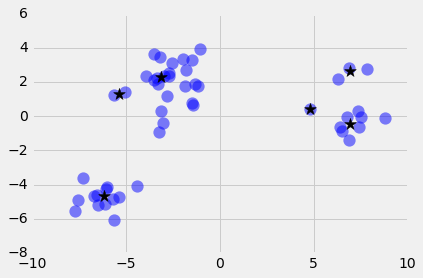

In [21]:
centroids = clf.centroids
# print(len(centroids))

plt.scatter(X[:,0], X[:,1], s=150, lw=0, alpha=0.5)

for c in centroids:
    plt.scatter(centroids[c][0], centroids[c][1], color='k', marker='*', s=150)

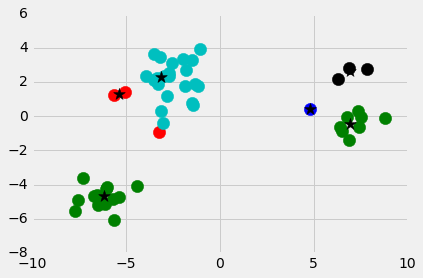

In [22]:
centroids = clf.centroids

for classification in clf.classifications:
    color=colors[classification]
    for featureset in clf.classifications[classification]:
        plt.scatter(featureset[0], featureset[1], marker='o', color=color,s=150)

for c in centroids:
    plt.scatter(centroids[c][0], centroids[c][1], color='k', marker='*', s=150)